# How do our aggregate models stack up?

In this notebook we examine the aggregate models obtained for galaxy builder galaxies, and compare these morels to various measures of ellipticity present in the NASA-Sloan Atlas, including an r-band single Sérsic compnent fit.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
import gzbuilder_analysis.fitting as fitting
from IPython.display import HTML

Load in needed assets

In [3]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)

In [4]:
df_nsa = pd.read_pickle('lib/df_nsa.pkl')

In [5]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([], dtype=object)  
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(
                    join(agg_res_path, f)
                )

100%|██████████| 296/296 [00:03<00:00, 88.25it/s]


In [6]:
fit_res_path = 'output_files/tuning_results'
fit_results = pd.Series([], dtype=object)  
with tqdm(os.listdir(fit_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pickle.gz', f):
                fit_results[int(f.split('.')[0])] = pd.read_pickle(
                    join(fit_res_path, f)
                )

100%|██████████| 297/297 [00:01<00:00, 211.85it/s]


In [7]:
agg_disks = agg_results.apply(lambda a: a.params.disk)
agg_disk_errors = agg_results.apply(lambda a: a.errors.disk)

In [8]:
fit_disks = fit_results.apply(pd.Series).final_model.apply(pd.Series).disk.apply(pd.Series)

Create a DataFrame with all the galaxy builder axis ratio measurements

In this cell we cross-match between Galaxy Builder subject IDs and NSA Ids using the metadata associated with each subject. We then Extract the relevant axial ratios from the NSA catalog, and pair it with those from the two Simard (2011) catalogs

In [81]:
axratios = (df_nsa.set_index('NSAID')[['SERSIC_BA', 'PETRO_BA90', 'PETRO_BA50']]
       .reindex(gu.metadata.reindex(agg_disks.index)['NSA id'].astype(np.int64).values)
       .assign(
           subject_id=agg_disks.index,
       )
       .reset_index()
       .set_index('subject_id')
       .assign(
           gzb=agg_disks.q,
           gzb_fit=fit_disks.q,
           e_gzb=agg_disk_errors.q,
           s_edv=np.cos(np.deg2rad(simard_df['i'])),
           e_s_edv=simard_df['e__B_T_r'],
           s_es=np.cos(np.deg2rad(simard_df_free['i'])),
           e_s_es=simard_df_free['e__B_T_r'],
       )
       .query('gzb_fit > 0.25')
)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


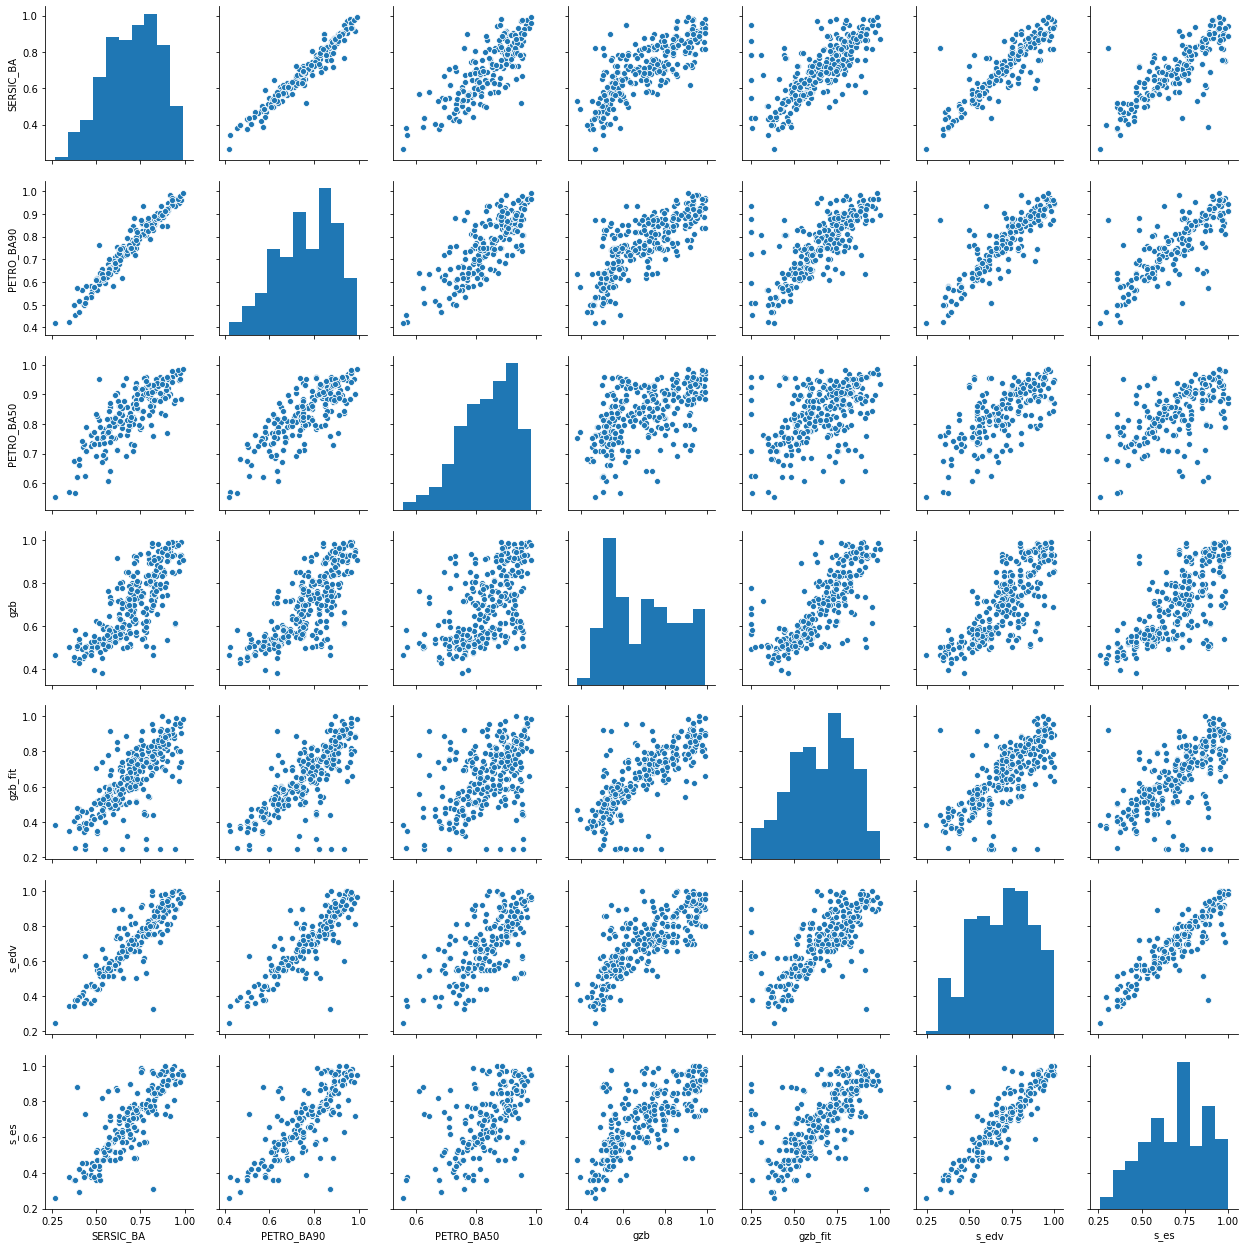

In [10]:
sns.pairplot(axratios.drop(columns=['NSAID', 'e_gzb', 'e_s_edv', 'e_s_es']))

In [11]:
int('111', 2)

7

In [12]:
m = agg_results.iloc[0].model
''.join('1' if m[c] is not None else '0' for c in ('disk', 'bulge', 'bar')) + ('1' if len(m['spiral']) else '0')

'1100'

In [13]:
def encode_comp(m):
    s = '+'.join([c for c in ('disk', 'bulge', 'bar') if m[c] is not None] + (['spiral'] if len(m['spiral']) else []))
    encoding = int(
        ''.join('1' if c in s else '0' for c in ('disk', 'bulge', 'bar', 'spiral')),
        2
    )
    return pd.Series(dict(str=s, encoding=encoding))
model_encoding = agg_results.apply(lambda a: a.model).apply(encode_comp)
model_encoding['str'].value_counts()

disk+bulge+spiral        118
disk+bulge                89
disk+bulge+bar+spiral     46
disk+bar+spiral           13
disk+bulge+bar            11
disk+spiral                9
disk                       8
disk+bar                   2
Name: str, dtype: int64

In [14]:
model_encoding[model_encoding.encoding == 10]['str'].iloc[0]

'disk+bar'

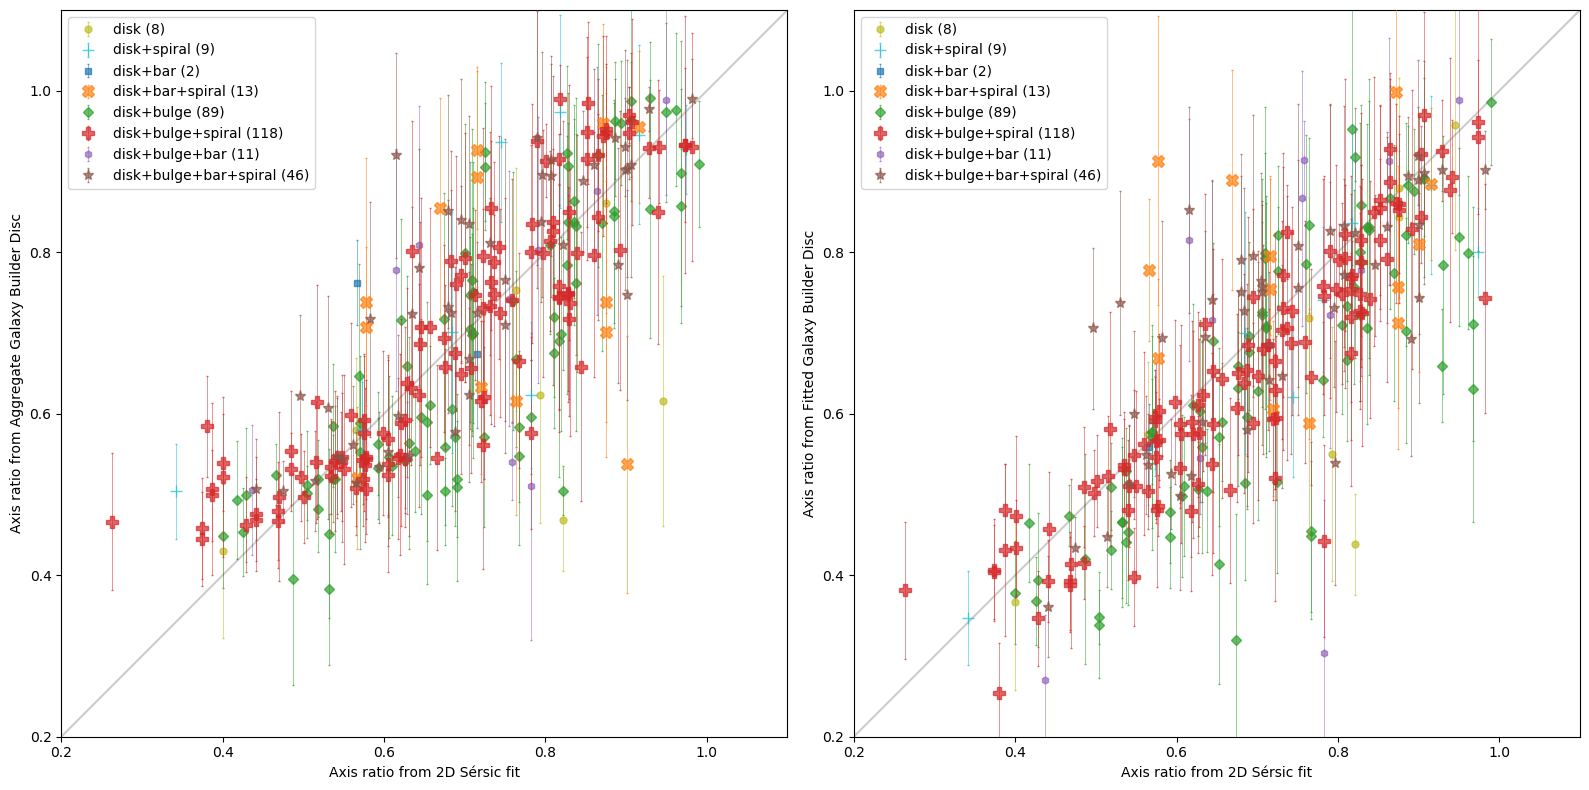

In [82]:
def get_kw(label):
    has_spiral = 'spiral' in label
    fmts = {
        'disk': 'o', 'disk+spiral': '+',
        'disk+bulge': 'D', 'disk+bulge+spiral': 'P',
        'disk+bar': 's','disk+bar+spiral': 'X',
        'disk+bulge+bar': 'h', 'disk+bulge+bar+spiral': '*',
    }
    return dict(
        linewidth=0.5, alpha=0.7,
        fmt=fmts[label],
        markersize=(8 if has_spiral else 5),
        zorder=(3 if has_spiral else 2),
        capsize=1,
    )

plt.figure(figsize=(8*2, 8), dpi=100)
plt.subplot(121)
ax = plt.gca()
for i in np.unique(model_encoding.encoding):
    mask = model_encoding.encoding == i
    label = model_encoding[mask]['str'].iloc[0]
    fmt = 'x' if 'spiral' in label else 'o'
    ms = 10 if 'spiral' in label else 5
    ax.errorbar(axratios['SERSIC_BA'][mask], axratios['gzb'][mask],
                yerr=axratios['e_gzb'][mask],
                c=f'C{i}', label=f'{label} ({mask.sum()})',  **get_kw(label))
ax.set_xlabel('Axis ratio from 2D Sérsic fit')
ax.set_ylabel('Axis ratio from Aggregate Galaxy Builder Disc');
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
plt.legend()
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.subplot(122)
ax = plt.gca()
for i in np.unique(model_encoding.encoding):
    mask = model_encoding.encoding == i
    label = model_encoding[mask]['str'].iloc[0]
    fmt = 'x' if 'spiral' in label else 'o'
    ms = 10 if 'spiral' in label else 5
    ax.errorbar(axratios['SERSIC_BA'][mask], axratios['gzb_fit'][mask],
                yerr=axratios['e_gzb'][mask],
                c=f'C{i}', label=f'{label} ({mask.sum()})',  **get_kw(label))
ax.set_xlabel('Axis ratio from 2D Sérsic fit')
ax.set_ylabel('Axis ratio from Fitted Galaxy Builder Disc');
plt.legend()
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.tight_layout()
plt.savefig('method-paper-plots/nsa_axratio_comparison.pdf', bbox_inches='tight')

In [83]:
(axratios['gzb'] - axratios['SERSIC_BA']).std()

0.09890742878960454

In [84]:
(axratios['gzb_fit'] - axratios['SERSIC_BA']).std(),

0.09919309285462082

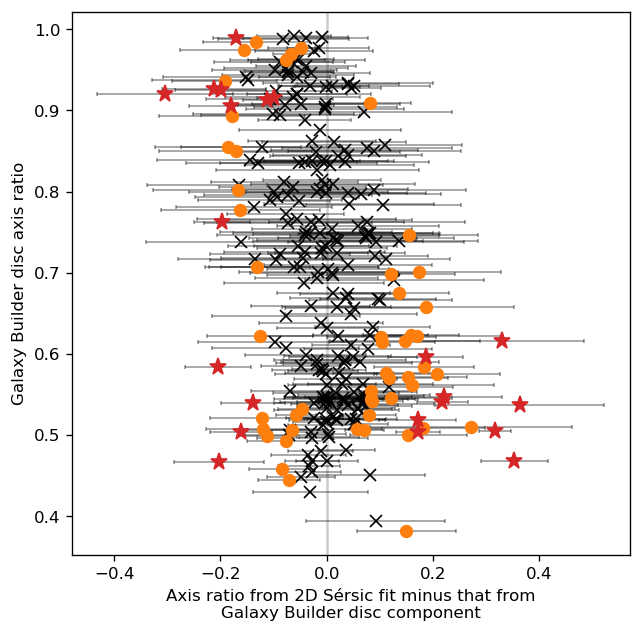

In [85]:
plt.figure(figsize=(6, 6), dpi=120)
f = ('x', 'o', '*')
c = ('k', 'C1', 'C3')
ms = (1, 1, 1.5)
for s in (0, 1, 2):
    sp1 = s + 1 if s < 2 else np.inf
    _df = axratios.query('@s * e_gzb < abs(SERSIC_BA - gzb) < @sp1 * e_gzb')
    plt.errorbar(
        _df['SERSIC_BA'] - _df['gzb'], _df['gzb'], 
        xerr=_df['e_gzb'], fmt=',', c='k',
        elinewidth=1, capsize=1, alpha=0.4)
    plt.errorbar(
        _df['SERSIC_BA'] - _df['gzb'], _df['gzb'],
        fmt=f[s], c=c[s], ms=ms[s]*7
    )
plt.xlabel('Axis ratio from 2D Sérsic fit minus that from\nGalaxy Builder disc component')
plt.ylabel('Galaxy Builder disc axis ratio')
plt.axvline(0, c='k', alpha=0.2)
plt.savefig('method-paper-plots/gzb-agg-nsa-comparison.pdf', bbox_inches='tight')

In [78]:
len(axratios.query('(gzb < 0.6) & (2 * e_gzb < abs(SERSIC_BA - gzb))')) / axratios.query('gzb < 0.6').shape[0]

0.10714285714285714

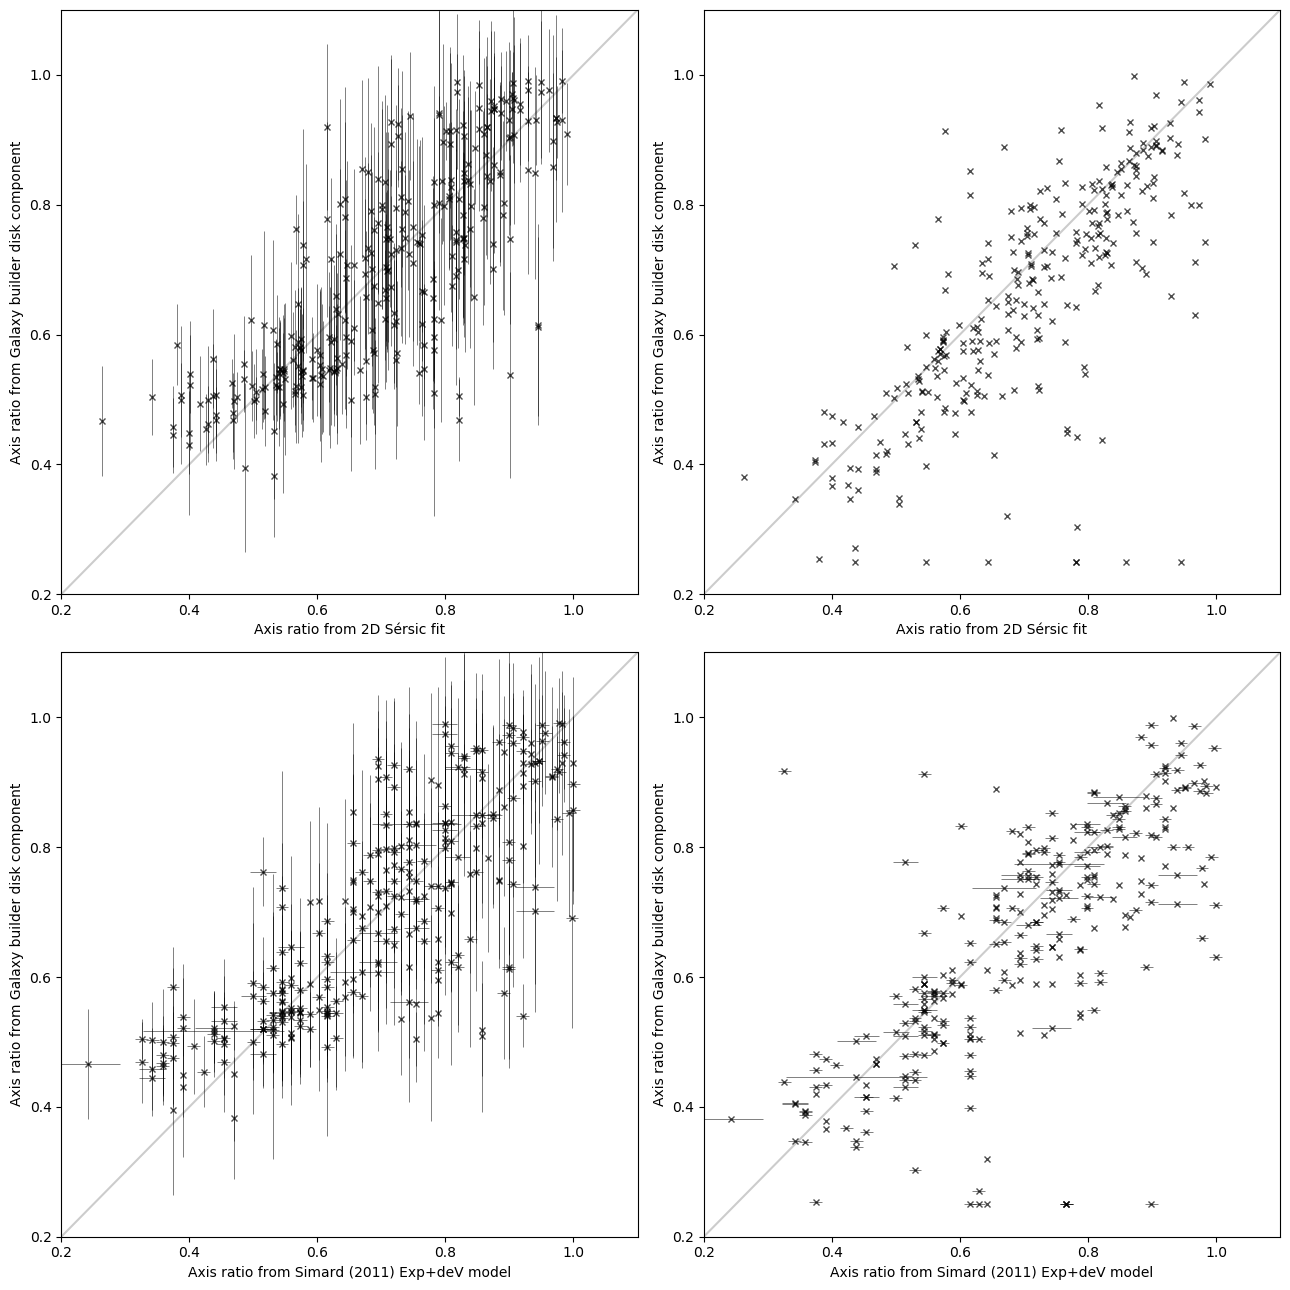

In [22]:
plt.figure(figsize=(13, 13), dpi=100)
plt.subplot(221)
ax = plt.gca()
ax.errorbar(axratios['SERSIC_BA'], axratios['gzb'], fmt='xk',
               yerr=axratios['e_gzb'],
               markersize=5, linewidth=0.5, alpha=0.7)
ax.set_xlabel('Axis ratio from 2D Sérsic fit')
ax.set_ylabel('Axis ratio from Galaxy builder disk component');
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.subplot(222)
ax = plt.gca()
ax.errorbar(axratios['SERSIC_BA'], axratios['gzb_fit'], fmt='xk',
#                yerr=axratios['e_gzb'],
               markersize=5, linewidth=0.5, alpha=0.7)
ax.set_xlabel('Axis ratio from 2D Sérsic fit')
ax.set_ylabel('Axis ratio from Galaxy builder disk component');
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))

plt.subplot(223)
ax = plt.gca()
ax.errorbar(axratios['s_edv'], axratios['gzb'], fmt='xk',
            xerr=axratios['e_s_edv'],
            yerr=axratios['e_gzb'],
            markersize=5, linewidth=0.5, alpha=0.7)
ax.set_xlabel('Axis ratio from Simard (2011) Exp+deV model')
ax.set_ylabel('Axis ratio from Galaxy builder disk component');
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.subplot(224)
ax = plt.gca()
ax.errorbar(axratios['s_edv'], axratios['gzb_fit'], fmt='xk',
            xerr=axratios['e_s_edv'],
#             yerr=axratios['e_gzb'],
            markersize=5, linewidth=0.5, alpha=0.7)
ax.set_xlabel('Axis ratio from Simard (2011) Exp+deV model')
ax.set_ylabel('Axis ratio from Galaxy builder disk component');
ax.set_xlim(0.2, 1.1)
ax.set_ylim(0.2, 1.1)
ax.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.tight_layout()